# Fake news detection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [3]:
df = pd.read_csv(r'D:\news.csv' , engine = 'python')
fake = df.loc[df['label']=='FAKE']
true = df.loc[df['label']=='REAL']

In [4]:
fake.shape

(3164, 4)

In [5]:
true.shape

(3171, 4)

## Data cleaning and preparation

In [6]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

C:\Users\ANTPC~1\AppData\Local\Temp/ipykernel_6552/3221889680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake['target'] = 'fake'
C:\Users\ANTPC~1\AppData\Local\Temp/ipykernel_6552/3221889680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true['target'] = 'true'


In [34]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(6335, 5)

In [35]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [36]:
# Check the data
data.head()

,Unnamed: 0,title,text,label,target
0,392,Why These Democrats Flipped To Defeat Wall Str...,WASHINGTON -- Anyone who wants to understand t...,REAL,true
1,8662,Economic upgrade: Russia receives multiple end...,"Thu, 27 Oct 2016 16:35 UTC © UPI.com Successfu...",FAKE,fake
2,2844,Jeb Bush blames Iraq unrest on Obama,"The former Florida governor, appearing at a bu...",REAL,true
3,2949,Saudi Arabia says farewell to King Abdullah,(CNN) Thousands gathered in Riyadh on Friday t...,REAL,true
4,10001,What A Hillary Presidency Would Bring,"Behind the headlines - conspiracies, cover-ups...",FAKE,fake


In [37]:
# # Removing the date (we won't use it for the analysis)
# data.drop(["date"],axis=1,inplace=True)
# data.head()

In [38]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,Unnamed: 0,text,label,target
0,392,WASHINGTON -- Anyone who wants to understand t...,REAL,true
1,8662,"Thu, 27 Oct 2016 16:35 UTC © UPI.com Successfu...",FAKE,fake
2,2844,"The former Florida governor, appearing at a bu...",REAL,true
3,2949,(CNN) Thousands gathered in Riyadh on Friday t...,REAL,true
4,10001,"Behind the headlines - conspiracies, cover-ups...",FAKE,fake


In [39]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,Unnamed: 0,text,label,target
0,392,washington -- anyone who wants to understand t...,REAL,true
1,8662,"thu, 27 oct 2016 16:35 utc © upi.com successfu...",FAKE,fake
2,2844,"the former florida governor, appearing at a bu...",REAL,true
3,2949,(cnn) thousands gathered in riyadh on friday t...,REAL,true
4,10001,"behind the headlines - conspiracies, cover-ups...",FAKE,fake


In [40]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [41]:
# Check
data.head()

,Unnamed: 0,text,label,target
0,392,washington anyone who wants to understand the...,REAL,true
1,8662,thu 27 oct 2016 1635 utc © upicom successful e...,FAKE,fake
2,2844,the former florida governor appearing at a bus...,REAL,true
3,2949,cnn thousands gathered in riyadh on friday to ...,REAL,true
4,10001,behind the headlines conspiracies coverups an...,FAKE,fake


In [42]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
data.head()

,Unnamed: 0,text,label,target
0,392,washington anyone wants understand current sta...,REAL,true
1,8662,thu 27 oct 2016 1635 utc © upicom successful e...,FAKE,fake
2,2844,former florida governor appearing business rou...,REAL,true
3,2949,cnn thousands gathered riyadh friday say farew...,REAL,true
4,10001,behind headlines conspiracies coverups ancient...,FAKE,fake


## Basic data exploration

In [44]:
# # How many articles per subject?
# print(data.groupby(['subject'])['text'].count())
# data.groupby(['subject'])['text'].count().plot(kind="bar")
# plt.show()

target
fake    3164
true    3171
Name: text, dtype: int64


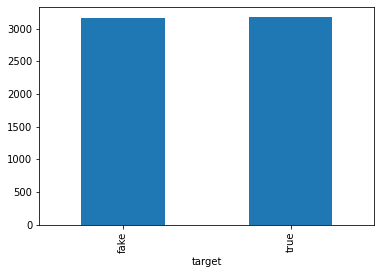

In [45]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

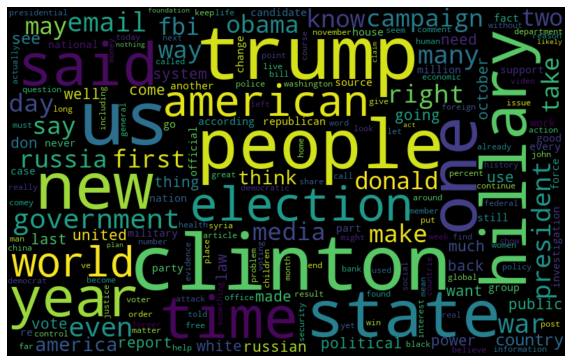

In [46]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

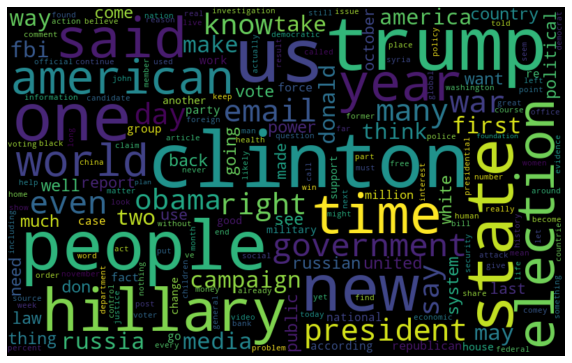

In [47]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [48]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

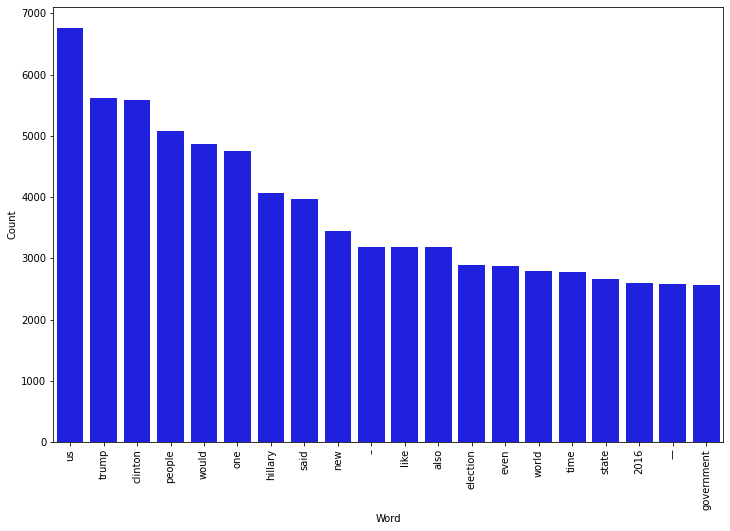

In [49]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

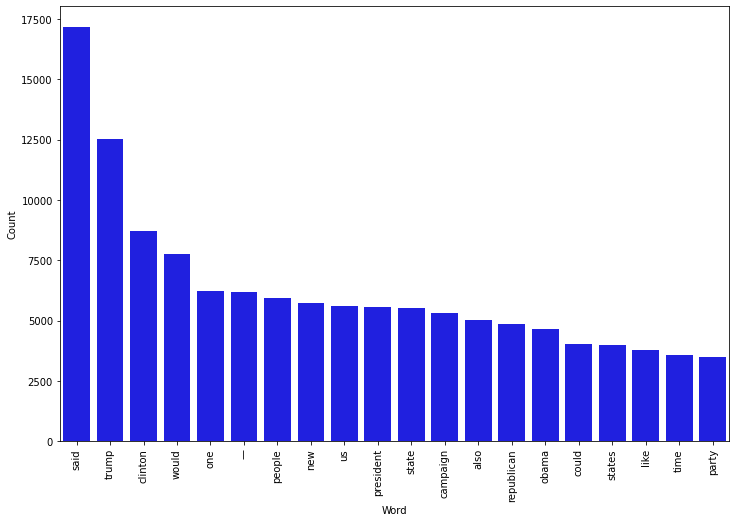

In [50]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [51]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [52]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Logistic regression

In [53]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 92.03%


Confusion matrix, without normalization


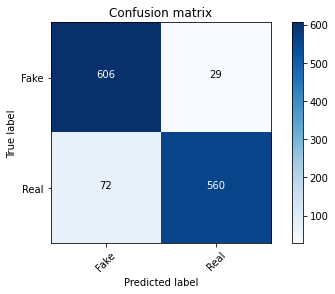

In [54]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree Classifier

In [55]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 82.79%


Confusion matrix, without normalization


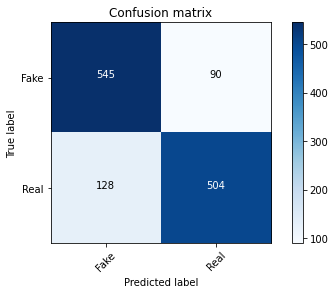

In [56]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Classifier

In [57]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 89.66%


Confusion matrix, without normalization


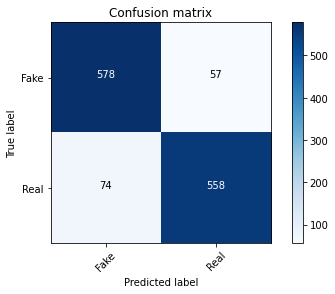

In [58]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])